<p><img src="https://github.com/lewis060-UAT/DAYB/blob/master/IBA_LOGO.png?raw=true" alt="Drawing" style="width: 450px;float: right;"/>

#### This Jupyter Notebook highlights the "Step-by-Step" analytic procedures of a GIS model examine geospatial acess to dental health care among youth in Alabama. Full details of the study  are presented in _"Visualizing the Potential Impact of Dental Retirements on Spatial Accessibility to Dental Care among Alabama’s Youth"_  by Samsel et al. (2020), which is available for download at: URL Here.
Additional credit for the development of this notebook should go to Dr. Nickolas Freeman and Mr. Ryan Tramp.

The following code block imports the libraries that will be used.<br>Note: ArcGIS was used to render maps in manuscript. _Geopandas_ is used in this notebook to render results.

In [1]:
import os

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)
import seaborn as sns
sns.set_style('whitegrid')

Our analysis focuses on answering two questions:
1. Assuming that the current group of dental care providers is practicing and will continue to practice, what is accessibility for youth by AL county?
2. Assuming that the current dental care providers retire at expected rates, with no new entrants, what is the impact on accessibility for youth by AL county?

We use the two-step floating catchment area method outlined in the paper "Geographic access to dental care varies in Missouri and Wisconsin" to answer the first question. The citation for the paper is:
> Nasseh K, Eisenberg Y, Vujicic M. Geographic access to dental care varies in Missouri and Wisconsin. (2017) Journal of Public Health Dentistry. 77(3): 197‐206. doi:10.1111/jphd.12197

We use Monte Carlo simulation to answer the second question. The following code block specifies the number of replications that will be used for the simulation and also sets the random seed for the random number generator.

In [2]:
REPLICATIONS = 30
RANDOM_STATE = 0

### Helper function

The following code blocks defines a helper function, `apply_efficiency_map`. The function applies an *efficiency map* to a user-specified column of a `pandas` `DataFrame` object that is passed as the first required argument and includes details on the age of providers. The *efficiency map* essentially captures the relative efficiency of the provider as a function of his/her age and is specified using a dictionary. By default, the function uses the mapper:

```python
efficiency_mapper = {
    (0, 55): 1.04,
    (55, 60): 1.03,
    (60, 64): 0.96,
    (64, 999): 0.82,
}
```
The default efficiency mapper that we used is the same as that used in the previously cited research by Nasseh, Eisenberf, and Vujicic (see Table A1 of the paper). As you can see, the keys of the dictionary are tuples that map to possible age values. For example, the key (0, 55) will apply to providers whose age is greater than or equal to zero and less than 55, i.e., the right endpoint is not inclusive. The values associated with each key represent the relative efficiency of the age group, with higher values indicating higher efficency.

In [3]:
def apply_efficiency_map(provider_df, 
                         efficiency_mapper = {
                             (0, 55): 1.04,
                             (55, 60): 1.03,
                             (60, 64): 0.96,
                             (64, 999): 0.82,
                         },
                         column_to_map = 'Age_as_of_JUL2019',
                         return_column = 'Prov_Efficiency',
                        ):
    '''
    A helper function for mapping provider ages to efficiency scores. Returns a
    copy of df with a new column (return_column) that specifies the efficiency 
    score for all providers.
    
    Arguments:
    provider_df - a DataFrame with each row specifying the details for a single
        provider and at least one numeric column specifying each provider's age
    efficiency_mapper - a dictionary that specifies the efficiency mapping. The
        keys of the dictionary should be a tuple specifying the low and high
        age values for a particular efficiency value (the values in the dictionary).
        The default mapper is:
            efficiency_mapper = {
                (0, 55): 1.04,
                (55, 60): 1.03,
                (60, 64): 0.96,
                (64, 999): 0.82,
            }
        As an example, the key (0, 55) applies to providers whose age is greater than 
        or equal to zero and less than 55, i.e., the right endpoint is not inclusive.
    column_to_map - the numeric column including the age values
    return_column - specifies a new column name where the mapped efficiency values are
        stored in the returned copy of df            
    '''
    
    for key in efficiency_mapper.keys():
        mask = ((provider_df[column_to_map] >= key[0])
                & (provider_df[column_to_map] < key[1]))
        provider_df.loc[mask, return_column] = efficiency_mapper[key]
    
    return provider_df

# Data

Our primary analysis uses the following data sources:
1. Data regarding the youth population by census block in the state of Alabama (stored in `pop_table`),
2. Data regarding providers in the state of Alabama and bordering counties in other states (stored in `prov_table`), and
3. Data regarding the distance (miles) and travel time (minutes) between all provider locations and populated census blocks (stored in `matrix_table`).

The following code block reads in the various data files and performs some basic modifications. **Note: To limit the data size, we only include (provider, GEOID) pairs that are within 120 minutes of one another in the `matrix_table`. Travel time matrix was generated using ESRI StreetMap Premium for travel on Monday's at 8:00AM** 

In [4]:
# read table including population information
# and fill spaces in column names with underscores
pop_table = pd.read_pickle('data/pop_table.pkl.gz')
print('Population table read')

# read table including provider information
# and fill spaces in column names with underscores
prov_table = pd.read_pickle('data/prov_table.pkl.gz')
print('Provider table read')

# read table including distance information
# and fill spaces in column names with underscores
matrix_table = pd.read_pickle('data/matrix_table.pkl.gz')
print('Distance matrix read')

# The following lines identify providers that are in
# both the distance table and the provider information
# table. We remove any providers from these tables that
# do not appear in both.
matrix_providers = matrix_table['Prov_ID'].unique().tolist()
prov_table_providers = prov_table['Prov_ID'].unique().tolist()
common_providers = set(matrix_providers).intersection(set(prov_table_providers))
common_providers = list(common_providers)
prov_table = prov_table[prov_table['Prov_ID'].isin(common_providers)]
matrix_table = matrix_table[matrix_table['Prov_ID'].isin(common_providers)]
print('matrix_table and prov_table restricted to common providers')

# apply efficiency mapping to prov_table
prov_table = apply_efficiency_map(prov_table)
prov_table = prov_table.reset_index(drop = True)
print('Provider efficency mapped to prov_table')

Population table read
Provider table read
Distance matrix read
matrix_table and prov_table restricted to common providers
Provider efficency mapped to prov_table


The first five rows of the `pop_table` object are shown below. Descriptions for the columns are:
- GEOID: US Census Assigned ID for respective Block Group
- Total_Youth_Pop: Total youth population
- COUNTYFP: Three digit US Census county identifier

In [5]:
pop_table.head()

,GEOID,Total_Youth_Pop,COUNTYFP
0,010010201001,188.0,001
1,010010201002,290.0,001
2,010010202001,353.0,001
3,010010202002,264.0,001
4,010010203001,697.0,001


The first five rows of the `prov_table` object are shown below. Descriptions for the columns are:
- Prov_ID: Assigned provider ID
- Age_as_of_JUL2019: Age (in years) of provider as of July 1, 2019
- Retention_Rate: 1 - retirement rate for provider based on age group
- Prov_Efficiency: Efficiency score for provider based on age group (defined by efficiency_mapper dictionary passed to `apply_efficiency_map` function 

The retention rates we use are based on those specified in:
> Munson, B., & Vujicic, M. (2018). Supply of full-time equivalent dentists in the US expected to increase steadily. Health Policy Institute Research Brief. American Dental Association. July.

Age Group | Probability Retire (%) | Retention Rate
----------|----------|----------
34 and younger | 2.5 | 0.975
35-44 | 2.3 | 0.977
45-54 | 4.0 | 0.960
55-64 | 15.9 | 0.841
65-74 | 40.9 | 0.591
75-84 | 61.4 | 0.386
85 and older | 80.6 | 0.194

In [6]:
prov_table.head()

,Prov_ID,Age_as_of_JUL2019,Retention_Rate,Prov_Efficiency
0,1,35,0.977,1.04
1,2,51,0.960,1.04
2,3,60,0.841,0.96
3,4,57,0.841,1.03
4,5,48,0.960,1.04


The first five rows of the `matrix_table` object are shown below. Descriptions for the columns are:
- GEOID: US Census Assigned ID for respective Block Group
- Prov_ID: Assigned provider ID
- Total_Minutes: Travel time (in minutes) between provider and GEOID

In [7]:
matrix_table.head()

,GEOID,Prov_ID,Total_Minutes
1182,010010201001,4,90.661117
1265,010010201001,5,93.883782
1334,010010201001,6,53.710452
1402,010010201001,7,60.279928
82,010010201001,11,83.782582


# Retirement Simulation

We use a binomial distribution to create retirement scenarios that will be used for our Monte Carlo simulation looking at the impact of dentist retirements. Recall that if a random variable $X$ follows a binomial distribution with parameters $n\in\mathcal{N}$ and $p\in [0,1]$, which we write as $X \sim~ B(n, p)$, the probability of getting $k$ successes in $n$ independent Bernoulli trials is given by the probability mass function:

$$\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}\mbox{, where } \binom{n}{k}={\frac {n!}{k!(n-k)!}}.$$

To simulate retirements, we are simply creating scenarios that represent whether or not individual providers continue to practice based on their age-specific retirement likelihood. For this purpose, we use a binomial distribution with $n = k = 1$ and a probability of success that is equal to the probability that the provider *does not retire*. We generate a binomial variable for each provider and each replication as a matrix using `numpy`'s random number generation capabilities. Thus, if we have $r$ replications and $m$ providers, we generate a $r\times m$ matrix, where each value $(i, j)$, $i\in\{1,\ldots,r\}$, $j\in\{1,\ldots,m\}$, in the matrix is either 1, indicating that provider $j$ continues to practice in replication $i$, or 0, indicating that provider $j$ does not continue to practice in replication $i$, i.e., the provider retires.    

The following code block generates the random variables and joins it to the existing data in the `matrix_table` object.

In [8]:
sim_columns = [f'sim{i+1}' for i in range(REPLICATIONS)]

if sim_columns[0] in matrix_table.columns:
    print(f'It seems that you have already ran this cell. Restart and run all cells to rerun the analysis.')
else:
    base_cols = prov_table.columns.tolist()
    np.random.seed(RANDOM_STATE)
    sim_columns = [f'sim{i+1}' for i in range(REPLICATIONS)]
    sim_vals = np.random.binomial(
        n = 1,
        p = prov_table['Retention_Rate'],
        size = (REPLICATIONS, prov_table.shape[0])
    )
    sim_vals = sim_vals.T
    prov_table = prov_table.join(pd.DataFrame(sim_vals))
    prov_table.columns = base_cols + sim_columns

    matrix_table = matrix_table.merge(
        pop_table[['Total_Youth_Pop','GEOID']], 
        left_on = ['GEOID'], 
        right_on = ['GEOID']
    ).merge(
        prov_table[['Prov_ID', 'Prov_Efficiency'] + sim_columns], 
        left_on = ['Prov_ID'], 
        right_on = ['Prov_ID']
    )

matrix_table.head()

,GEOID,Prov_ID,Total_Minutes,Total_Youth_Pop,Prov_Efficiency,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9,sim10,sim11,sim12,sim13,sim14,sim15,sim16,sim17,sim18,sim19,sim20,sim21,sim22,sim23,sim24,sim25,sim26,sim27,sim28,sim29,sim30
0,010010201001,4,90.661117,188.0,1.03,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0
1,010010201002,4,89.436192,290.0,1.03,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0
2,010010202001,4,86.584428,353.0,1.03,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0
3,010010202002,4,88.083864,264.0,1.03,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0
4,010010203001,4,88.425708,697.0,1.03,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0


# Accessibility Calculations

The two-step floating catchment area (2SFCA) method involves two significant steps. 

The first step in this approach is to compute a supply-to-demand ratio ($R_j$) for each dental location ($j$). The demand is approximated by aggregating the population for block groups that may be reached within a specified (a prioiri) time threshold $d_{0}$. The supply, or full-time equivalent (FTE) availability, for dental location $j$ is obtained based on the efficiency mapping applied to the provider data and is multipled by 1,000 for ease of interpretation. In particular, this multiplication modifies the supply-to-demand ratio so that it represent an approximation of the number of dentists per 1,000 residents. Letting $D_{k}$ denote the poputulation for block group $k$, $K$ denote the set of block group locations, $d_{jk}$ denote the distance between provider location $j$ and block group $k$, and $S_{j}$ denote the scaled supply for dental location $j$, the mathematical representation of our supply-to-demand ratio is:

$$R_{j} = \frac{1000 S_{j}}{\sum_{k\in K:d_{kj}\leq d_{0}}D_{k}}$$


The second step of the approach consists of summing all the supply-to-demand dental ratios, $R_j$, that are within a prespecified catchment threshold for each population block group $k$. This summation yields an aggregate accessibility score, $A_k$, that represents the number of dentists per 1000 residents in block group $k$. Letting $J$ denote the set of dental locations, the mathematical representation of this accessibility score is:

$$A_{k} = \sum_{j\in J:d_{kj}\leq d_{0}}R_{j}.$$ 

The following code block defines a function that applies the described 2SFCA method to our data. In the function, the supply-to-demand ratio is stored in the `Initial_Ratio` column of a temporary DataFrame. These initial ratios are then mapped to their corresponding `Prov_ID` in the `distance_table` to prepare for the next step. 

In [9]:
def apply_2SFCA(distance_table,
                population_table,
                cutoff = 30,
                include_plot = False,
                efficiency_mapper = {
                    (0, 55): 1.04,
                    (55, 60): 1.03,
                    (60, 64): 0.96,
                    (64, 999): 0.82,
                }):
    '''
    apply_2SFCA utilizes the data provided to create an accessibility score for a particular GEOID.
    Returns a dataframe with the accessibility scores for a particular GEOID and has the option to output a histogram
    plot of the accessibility data.
    
    Arguments:
    distance_table - The distance table refers to the matix table above and should include the following columns in order
    to function properly
    
                Total Minutes   : Total minutes refers to the amount of travel time it takes to go between a GEOID and
                a Prov_ID.
                GEOID           : The unique identification number of a population block.
                Prov_ID         : The unique identification number of a dental provider.
                Prov_Efficiency : The FTE (Full Time Equivalent) value of a provider.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                
    population_table - The population table refers to the population table above and should include the following columns in order
    to function properly and is used display the final results
    
                GEOID           : The unique identification number of a population block.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                COUNTYFP        : The unique identification number of a county in Alabama.
                
    cutoff - Default set to 30 minutes. The cutoff is the amount of time a person is willing to travel before they decide to quit looking
    for a dental provider. Value is in minutes.
    
    include_plot - Boolean. Adds a histogram plot with the score as the x-axis and the frequency as the y-axis.
    
    efficiency_mapper - a dictionary that specifies the efficiency mapping. The
        keys of the dictionary should be a tuple specifying the low and high
        age values for a particular efficiency value (the values in the dictionary).
        The default mapper is:
            efficiency_mapper = {
                (0, 55): 1.04,
                (55, 60): 1.03,
                (60, 64): 0.96,
                (64, 999): 0.82,
            }
    
    '''

    import time
    start = time.time()
    
    distance_mask = distance_table['Total_Minutes'] <= cutoff
    distance_table = distance_table[distance_mask]
    #Step 1
    temp = distance_table.groupby(['Prov_ID','Prov_Efficiency'])['Total_Youth_Pop'].sum()
    temp = temp.reset_index()
    temp['Initial_Ratio'] = temp.eval('Prov_Efficiency/Total_Youth_Pop')*1000
    prov_to_ratio_mapper = temp.set_index('Prov_ID')['Initial_Ratio'].to_dict()
    
    distance_table['Initial_Ratio'] = distance_table['Prov_ID'].map(prov_to_ratio_mapper)
    #Step 2
    GEOID_to_score_mapper = distance_table.groupby('GEOID')['Initial_Ratio'].sum().to_dict()
    population_table.loc[:, 'Score'] = population_table['GEOID'].map(GEOID_to_score_mapper).fillna(0)
    
    print(f'Completed in {np.round(time.time() - start, 3)} seconds')
    
    if include_plot:
        import matplotlib.pyplot as plt
        import warnings
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            fig, ax = plt.subplots(1, 1, figsize = (8, 5))
            ax.hist(
                population_table['Score'].values,
                edgecolor = 'k',
                bins = 20,
            )

            plt.show()
    
    return population_table

The following plot demonstrates the use of the previously defined functions. As you can see, setting the `include_plot` argument to `True` will generate a histogram of the accessibility scores determined by the method.

Completed in 0.272 seconds


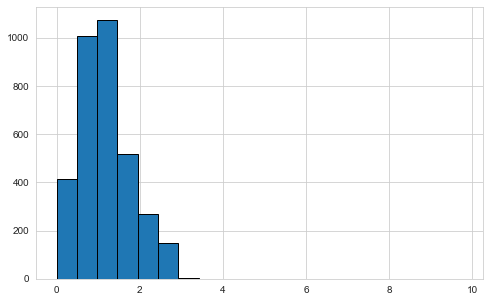

,GEOID,Total_Youth_Pop,COUNTYFP,Score
0,010010201001,188.0,001,0.737790
1,010010201002,290.0,001,0.323221
2,010010202001,353.0,001,0.702847
3,010010202002,264.0,001,0.751549
4,010010203001,697.0,001,0.681112
...,...,...,...,...
3432,011339658004,239.0,133,0.739654
3433,011339658005,299.0,133,0.564001
3434,011339659001,185.0,133,0.676255
3435,011339659002,258.0,133,1.320463


In [10]:
apply_2SFCA(matrix_table, pop_table, include_plot = True)

The following block below renders accessibility on a map.
Map below using Jenk's Breaks for classification, while 

Completed in 0.195 seconds


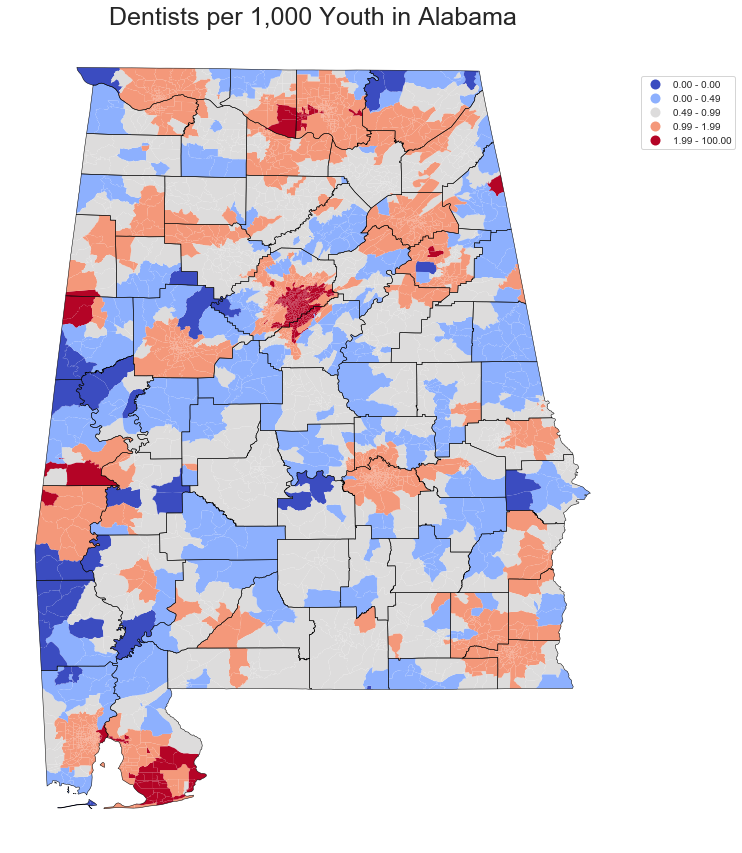

In [11]:
bg = "data/cb_2016_01_bg_500k.shp"
co = "data/Bama.shp"
access_df = apply_2SFCA(matrix_table, pop_table)
bg_df = gpd.read_file(bg)
co_df = gpd.read_file(co)
f, ax = plt.subplots(1, figsize=(15, 15))
merged = bg_df.set_index('GEOID').join(access_df[['GEOID','Score']].set_index('GEOID'))
ax = merged.plot(ax=ax, zorder=1, column="Score", legend=True, 
                 linewidth=0, scheme='User_Defined', 
                 cmap='coolwarm',classification_kwds=dict(bins=[0,0.49,0.99,1.99,100]))
ax = co_df.plot(ax=ax, zorder=2, facecolor="none",edgecolor='black', linewidth=0.5)
ax.axis('off')
ax.set_title('Dentists per 1,000 Youth in Alabama', fontdict={'fontsize': '25', 'fontweight' : '3'})
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.0, 0.0, 1.2, 0.95))
plt.show()

The following code block extends the `apply_F2PCA` function to consider the simulated retirement values. 

In [12]:
def apply_2SFCA_sim(distance_table,
                    population_table,
                    cutoff = 30,
                    efficiency_mapper = {
                        (0, 55): 1.04,
                        (55, 60): 1.03,
                        (60, 64): 0.96,
                        (64, 999): 0.82,
                    }):
    '''
 apply_2SFCA_sim creates simulated accessibility scores based off whether a provider was to retire or not and how that
 effects the accessibility for each population block. The function returns a dataframe with the original accessibility score
 and the simulated accessibility scores if some providers were to retire.
 
 Arguements:
    distance_table - The distance table refers to the matix table above and should include the following columns in order
    to function properly
    
                Total Minutes   : Total minutes refers to the amount of travel time it takes to go between a GEOID and
                a Prov_ID.
                GEOID           : The unique identification number of a population block.
                Prov_ID         : The unique identification number of a dental provider.
                Prov_Efficiency : The FTE (Full Time Equivalent) value of a provider.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                
    population_table - The population table refers to the population table above and should include the following columns in order
    to function properly and is used display the final results
    
                GEOID           : The unique identification number of a population block.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                COUNTYFP        : The unique identification number of a county in Alabama.
                
    cutoff - Default set to 30 minutes. The cutoff is the amount of time a person is willing to travel before they decide to quit looking
    for a dental provider. Value is in minutes.
    
    efficiency_mapper - a dictionary that specifies the efficiency mapping. The
        keys of the dictionary should be a tuple specifying the low and high
        age values for a particular efficiency value (the values in the dictionary).
        The default mapper is:
        
            efficiency_mapper = {
                (0, 55): 1.04,
                (55, 60): 1.03,
                (60, 64): 0.96,
                (64, 999): 0.82,
            }                    
    '''

    import time
    start = time.time()
    #Step 1
    distance_mask = distance_table['Total_Minutes'] <= cutoff
    distance_table = distance_table[distance_mask]

    temp = distance_table.groupby(['Prov_ID','Prov_Efficiency'])['Total_Youth_Pop'].sum()
    temp = temp.reset_index()
    temp['Initial_Ratio'] = (temp['Prov_Efficiency']/temp['Total_Youth_Pop'])*1000
    prov_to_ratio_mapper = temp.set_index('Prov_ID')['Initial_Ratio'].to_dict()
    distance_table['Initial_Ratio'] = distance_table['Prov_ID'].map(prov_to_ratio_mapper)
    
    #Collect simulated retirement value from the distance table
    
    sim_columns = [col for col in distance_table.columns if col.startswith('sim')]
    distance_table[sim_columns] = distance_table[sim_columns].multiply(
        distance_table['Initial_Ratio'], 
        axis = 'index'
    )
    #Step 2
    GEOID_to_score_mapper = distance_table.groupby('GEOID')[sim_columns].sum()
    GEOID_to_score_mapper['values'] = GEOID_to_score_mapper.values.tolist()
    GEOID_to_score_mapper = GEOID_to_score_mapper['values'].to_dict()

    temp = pd.DataFrame.from_dict(GEOID_to_score_mapper).transpose()
    temp.columns = sim_columns
    temp = temp.reset_index()
    temp = temp.rename(columns = {'index': 'GEOID'})
    population_table = population_table.merge(temp, how = 'left')
    population_table.loc[:, sim_columns] = population_table.loc[:, sim_columns].fillna(0)
    
    print(f'Completed in {np.round(time.time() - start, 3)} seconds')
    
    return population_table

The following code block demonstrates the use of the previously defined `apply_2SFCA_sim` function and prints the first 5 rows of the returned object. The values in the `Score` column indicate the accessibility score for each GEOID based on the current providers. The values in each column with the `sim` prefix provide the accessibility scores for the replication indicated by the number in the colum name.

In [13]:
sim_results = apply_2SFCA_sim(matrix_table, pop_table)
sim_results.head()

Completed in 0.967 seconds


,GEOID,Total_Youth_Pop,COUNTYFP,Score,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9,sim10,sim11,sim12,sim13,sim14,sim15,sim16,sim17,sim18,sim19,sim20,sim21,sim22,sim23,sim24,sim25,sim26,sim27,sim28,sim29,sim30
0,010010201001,188.0,001,0.737790,0.628014,0.539714,0.639919,0.608370,0.504328,0.651703,0.565118,0.538442,0.589926,0.609526,0.562427,0.597016,0.591274,0.662097,0.635413,0.625044,0.624785,0.568235,0.631309,0.600808,0.552943,0.591521,0.640386,0.514702,0.604353,0.617769,0.579824,0.642087,0.590264,0.548213
1,010010201002,290.0,001,0.323221,0.244963,0.252400,0.277288,0.252419,0.267650,0.265630,0.240010,0.256314,0.269830,0.265842,0.253389,0.268001,0.240228,0.288434,0.283349,0.262801,0.261493,0.226618,0.260084,0.273135,0.235923,0.239465,0.287755,0.216664,0.260197,0.288041,0.225472,0.310180,0.256706,0.253051
2,010010202001,353.0,001,0.702847,0.603049,0.574041,0.571051,0.569645,0.552012,0.626738,0.600612,0.542223,0.577150,0.584561,0.584564,0.619153,0.556331,0.637132,0.566546,0.600079,0.599820,0.543270,0.606344,0.622945,0.585057,0.569936,0.605444,0.546816,0.579388,0.604993,0.558239,0.617121,0.565299,0.570350
3,010010202002,264.0,001,0.751549,0.641773,0.553474,0.653678,0.608370,0.518087,0.665462,0.578877,0.552201,0.603685,0.623285,0.576186,0.610775,0.605033,0.675857,0.649172,0.638804,0.638544,0.581994,0.645068,0.614567,0.566702,0.605280,0.654145,0.528461,0.618112,0.631528,0.593583,0.655846,0.604023,0.561972
4,010010203001,697.0,001,0.681112,0.571336,0.540116,0.583241,0.537933,0.518087,0.595026,0.578877,0.552201,0.533248,0.552848,0.562828,0.597417,0.534596,0.605420,0.578735,0.568367,0.568107,0.511558,0.574632,0.601209,0.553345,0.548200,0.583709,0.515104,0.547676,0.561091,0.536504,0.585409,0.533587,0.548615


# County Level Analysis

The remainder of this notebook presents a county level analysis for the accessibility simulation. The following code block reads in data that allows us to create a dictionary mapping the county FIP codes to county names. The dictionary is created and stored as the `county_mapper` object.

In [14]:
# from https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
county_mapper = pd.read_excel(
    'data/county_codes.xlsx',
    skiprows = 4,
    dtype = 'object'
)

AL_mask = county_mapper['State Code (FIPS)'] == '01'
county_mask = county_mapper['Summary Level'] == '050'
county_mapper = county_mapper[(AL_mask &  county_mask)]

county_mapper['Area Name (including legal/statistical area description)'] \
= county_mapper['Area Name (including legal/statistical area description)'].str.replace(' County', '')

county_mapper = county_mapper.set_index('County Code (FIPS)')
county_mapper = county_mapper['Area Name (including legal/statistical area description)']
county_mapper = county_mapper.to_dict()
print('County FIP -> County mapper created')

County FIP -> County mapper created


The following code block uses the simulation results and the county mapper to assess aggregate the accessibility simulation at a county level. In this case, we use a 30-minute travel time cutoff are shown below. We use the simulation to visualize the mean accessibility and variability in accessibility for each county using a scatterplot. 

In the scatterplot, each point represents a county and the size, i.e., diameter, of the point is based on the county's population. The horizontal placement of points is based on the mean accessibility observed over the simulation (denoted by $\mu$ in the plot). In general, higher mean accessibility scores indicate higher levels of spatial access for a particular county population. Each point's vertical placement is based on the coefficient of variation in accessibility scores observed in the simulation. The coefficient of variation is calculated by dividing the standard deviation in accessibility scores (denoted by $\sigma$ in the plot) by the mean. Essentially, it provides a measure of the variability in accessibility for a county, normalized by the county's mean accessibility. Higher coefficents of variation indicate higher degrees of sensitivity to dentist retirements.

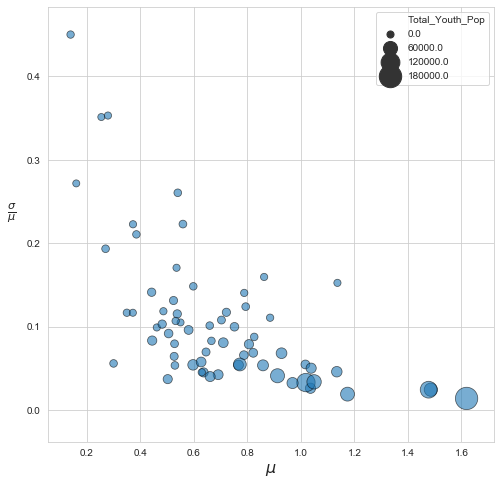

In [15]:
temp = sim_results.copy()
temp['County'] = temp['COUNTYFP'].map(county_mapper)
temp['County_Sum'] = temp.groupby('County')['Total_Youth_Pop'].transform('sum')
temp['GEOID_Prop'] = temp['Total_Youth_Pop']/temp['County_Sum']
sim_columns = [col for col in temp.columns if col.startswith('sim')]
temp[sim_columns] = temp[sim_columns].multiply(temp['GEOID_Prop'], axis = 'index')
temp = temp.groupby('County')[sim_columns + ['Total_Youth_Pop']].sum()
temp['County_Mean'] = temp[sim_columns].mean(axis = 1)
temp['County_Std'] = temp[sim_columns].std(ddof = 1, axis = 1)
temp['County_CV'] = temp['County_Std']/temp['County_Mean'] 

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

sns.scatterplot(x = 'County_Mean',
                y = 'County_CV',
                size = 'Total_Youth_Pop',
                edgecolor = 'k',
                sizes=(50, 500),
                alpha = 0.6,
                palette = 'bright',
                data = temp)

ax.set_xlabel(r'$\mu$', fontsize = 16)
ax.set_ylabel(r'$\frac{\sigma}{\mu}$', fontsize = 16, rotation = 0, labelpad = 15)

plt.show()

The defined function `interactive_plot1` the above simulation and converts it into an interactive plot where the user can change the travel time cutoff value and the number of clusters. 

The following code block defines a function, `interactive_plot`, that allows a user to perform the demonstrated county-level analysis for a user-specified travel time cutoff (via the `cutoff_val` parameter). It also includes the capacbility to perform a simple k-means cluster analysis using a user-specified number of clusters. The number of clusters to use is specified with the `n_clusters` argument, which defaults to 1.The cluster analysis uses the sckit-learn package `sklearn` (see https://scikit-learn.org/stable/index.html for more information). The k-means analysis attempts to group the datapoints into $k$ groups based on by similarities in both their coefficient of variations and their means. For a more indepth description of k-means analysis please see https://scikit-learn.org/stable/modules/clustering.html#k-means.

In [16]:
def interactive_plot(cutoff_val, nclusters = 1):
    '''
    Generates an interactive plot of accessibility scores given simulated retirement with the x-axis
    as the mean value of accessibility for a county, the y-axis as the coefficient of variation, and
    the size of the graph point representing the number of youth population served in a county.  
    
    Arguements:
        cutoff_val - A list of integers that represent travel times between GEOID locations and 
                     provider locations. Note large values will result in longer processing times.
        nclusters  - An integer that specifies the number of clusters to generate when running the 
                     Kmeans analysis. For interactivity, the widgets.IntSlider function is used. 
    
    
    '''

    sim_results = apply_2SFCA_sim(
        matrix_table, 
        pop_table, 
        cutoff = cutoff_val
    )
    
    temp = sim_results.copy()
    temp['County'] = temp['COUNTYFP'].map(county_mapper)
    temp['County_Sum'] = temp.groupby('County')['Total_Youth_Pop'].transform('sum')
    temp['GEOID_Prop'] = temp['Total_Youth_Pop']/temp['County_Sum']
    sim_columns = [col for col in temp.columns if col.startswith('sim')]
    temp[sim_columns] = temp[sim_columns].multiply(temp['GEOID_Prop'], axis = 'index')
    temp = temp.groupby('County')[sim_columns + ['Total_Youth_Pop']].sum()
    temp['County_Mean'] = temp[sim_columns].mean(axis = 1)
    temp['County_Std'] = temp[sim_columns].std(ddof = 1, axis = 1)
    temp['County_CV'] = (temp['County_Std']/temp['County_Mean']).fillna(0) 
    
    if nclusters > 1:
        from sklearn.cluster import KMeans

        temp_knn_model = KMeans(
            n_clusters = nclusters,
            random_state = 0,
            max_iter = 1000,
        )

        knn_array = temp[['County_Mean', 'County_CV']]
        kmeans_fit = temp_knn_model.fit(knn_array)
        temp['Cluster'] = kmeans_fit.predict(knn_array)
    else:
        temp['Cluster'] = 1

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    sns.scatterplot(x = 'County_Mean',
                    y = 'County_CV',
                    size = 'Total_Youth_Pop',
                    edgecolor = 'k',
                    hue = 'Cluster',
                    sizes=(50, 500),
                    alpha = 0.6,
                    palette = 'bright',
                    data = temp)

    ax.set_title(f'Scatterplot for Cutoff of {cutoff_val} Minutes',
                 fontsize = 14)
    ax.set_xlabel(r'$\mu$', fontsize = 16)
    ax.set_ylabel(r'$\frac{\sigma}{\mu}$', fontsize = 16, rotation = 0, labelpad = 15)

    plt.show()

The following code block uses the previously defined function, along with the interact function available in the `ipywidgets` library to generate an interactive plot that allows users to view changes in the mean accessibility and coefficient of variation of accessibility for varying travel time thresholds and number of cluster settings. **Note: To limit the data size, we only include (provider, GEOID) pairs that are within 120 minutes of one another. Thus, there will be no changes in the visual if you increase the `cutoff_val` above 120. Also, since the code block is utilizing an interactive widget it must be executed to display.**

In [ ]:
interact(interactive_plot, 
         cutoff_val = [10, 15, 30, 60, 120], 
         nclusters = widgets.IntSlider(min=1, max=10, step=1, value=1));